# Quantum Excess Evaluation Algorithm
Implementing [Quantum Computational Insurance and Actuarial Science](https://arxiv.org/html/2410.20841v1#S7.SS1)

In [1]:
# %pip install --force-reinstall -v "qiskit==1.4.2"
# %pip install qiskit-ibm-runtime --upgrade
# %pip install qiskit[visualization] --upgrade
# %pip install qiskit[all] --upgrade
# %pip install qiskit_aer --upgrade
# %pip install qiskit_algorithms --upgrade
# %pip install pylatexenc --upgrade

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qiskit

qiskit.__version__

'1.4.2'

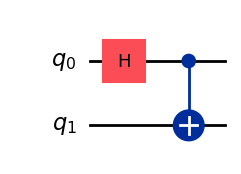

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')

In [4]:

from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [5]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()

EstimatorResult(values=array([ 1.        ,  0.00390625,  0.00390625,  1.        , -0.02148438,
       -0.02148438]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0051129, 'sample_measure_time': 0.0008082, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 14181, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9999847412109375, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0051129, 'sample_measure_time': 0.0008

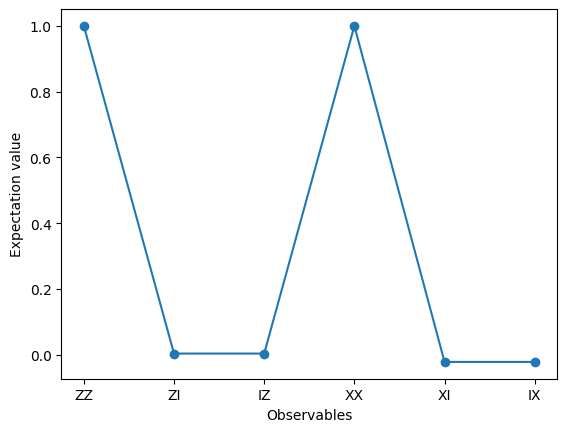

In [6]:
import matplotlib.pyplot as plt

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expectation value')
plt.show()

## Prepare State

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from scipy.stats import lognorm

# Parameters
num_qubits = 4  # Using 6 qubits for demonstration, scalable approach
domain_min = 0
domain_max = 10
deductible = 2.0  # Deductible amount
coins = 0.4
c_param = 1.5e-2 # <-- keep in sync with apply_excess_rotations

# Define lognormal distribution parameters
sigma = 1.0  # Shape parameter
mu = 0.0     # Scale parameter

def lognormal_loss(x):
    """Lognormal loss function"""
    return lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))

# Discretize domain into 2^num_qubits points
N = 2**num_qubits
step = (domain_max - domain_min) / (N - 1)
# Take the midpoint integral approximation to work on small number of qubits
mid_x_vals = np.linspace(
    domain_min + step / 2,
    domain_max - step / 2,
    N
)
probabilities = np.array([lognormal_loss(x) * step for x in mid_x_vals])
probabilities /= probabilities.sum()

# Full distribution for visualization
full_sims = 10_000
full_x_vals = np.linspace(domain_min, domain_max, full_sims)
full_step = (domain_max - domain_min) / (full_sims - 1)
full_mid_vals = np.linspace(
    domain_min + full_step / 2,
    domain_max - full_step / 2,
    full_sims
)
full_probabilities = np.array([lognormal_loss(x) * full_step for x in full_mid_vals])
full_probabilities /= full_probabilities.sum()

# Calculate amplitudes (square root of probabilities)
amplitudes = np.sqrt(probabilities)

# Create quantum circuit for state preparation
qc = QuantumCircuit(num_qubits)
qc.append(StatePreparation(amplitudes), range(num_qubits))

# Visualize the circuit (truncated for readability)
# qc.draw(output='mpl')

# Transpile the circuit to basic gates that Aer supports
qc = transpile(qc, basis_gates=['u3', 'cx'])
# qc.draw(output='mpl')

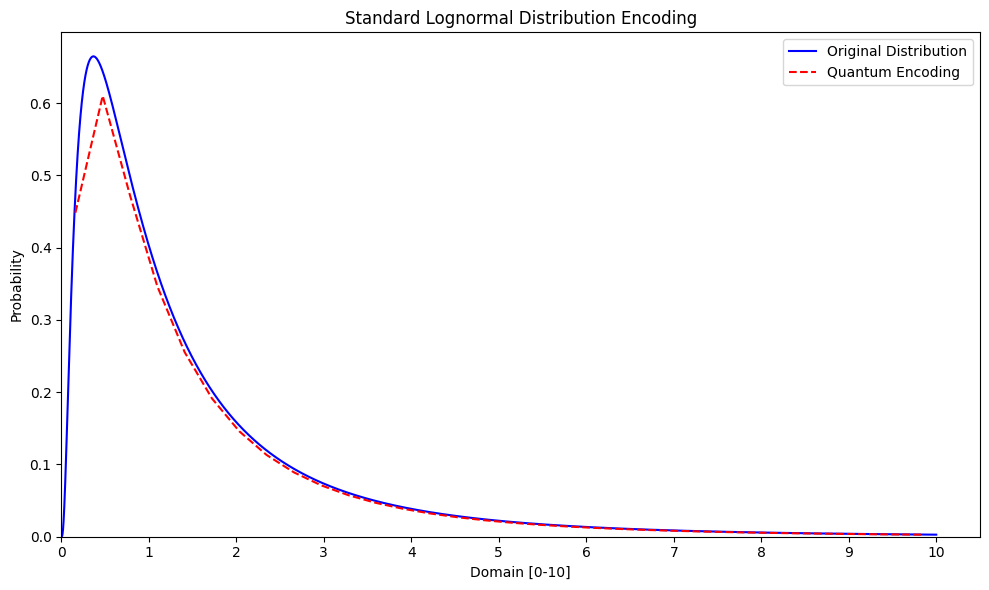

In [8]:
# Validate our state preparation by measuring
backend = Aer.get_backend('statevector_simulator')
statevector = backend.run(qc).result().get_statevector()

# Calculate the resulting probabilities
measured_probs = np.abs(statevector)**2

# Plot the original distribution vs quantum encoded distribution
plt.figure(figsize=(10, 6))
plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
plt.plot(mid_x_vals, measured_probs / step, 'r--', label='Quantum Encoding')
plt.xlabel('Domain [0-10]')
plt.ylabel('Probability')
plt.xticks(np.arange(domain_min, domain_max + 1, 1))
plt.title('Standard Lognormal Distribution Encoding')
plt.legend()
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()

# # Display the first few amplitudes
# print("First 10 amplitudes:")
# for i in range(10):
#     print(
#         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Plot State Degeneration With Decreased Qubits

In [9]:
# num_qubits_list = range(2, 8)
# N_list = [2**n for n in num_qubits_list]
# step_list = [(domain_max - domain_min) / (N - 1) for N in N_list]
# # Take the midpoint integral approximation to work on small number of qubits
# mid_x_vals_list = [np.linspace(domain_min + step / 2, domain_max - step / 2, N) for N in N_list]
# probabilities_list = []
# for i, N in enumerate(N_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = np.array([lognormal_loss(x) * step for x in x_vals])
#     probabilities /= probabilities.sum()
#     probabilities_list.append(probabilities)

# # Add Color
# cmap = plt.cm.get_cmap('Reds', len(num_qubits_list) + 2)

# # Plot the original distribution vs quantum encoded distribution
# plt.figure(figsize=(10, 6))
# plt.plot(full_x_vals, full_probabilities / full_step, 'b-', label='Original Distribution')
# for i, N in enumerate(num_qubits_list):
#     x_vals = mid_x_vals_list[i]
#     step = step_list[i]
#     probabilities = probabilities_list[i]
#     alpha = 1/(i/2 + 1)
#     plt.plot(x_vals, probabilities / step, 'r-', alpha=alpha, label=f'Quantum Encoding ({N} qubits)')
# plt.xlabel('Domain [0-10]')
# plt.ylabel('Probability')
# plt.xticks(np.arange(domain_min, domain_max + 1, 1))
# plt.title('Loss Distribution Degeneration')
# plt.legend()
# plt.tight_layout()
# plt.axis([0, None, 0, None])
# plt.show()

# # # Display the first few amplitudes
# # print("First 10 amplitudes:")
# # for i in range(10):
# #     print(
# #         f"State |{i}⟩: √p_j = {amplitudes[i]:.6f}, p_j = {probabilities[i]:.6f}")

### Diagnostic

## Implement Quantum Subtraction

In [10]:
# index of the first grid‑point *above* the deductible
step         = (domain_max - domain_min) / (N - 1)
threshold_idx = np.searchsorted(mid_x_vals, deductible, side="left")
print(f"threshold = {threshold_idx}")
print(f"binary threshold = {threshold_idx:0{num_qubits}b}")

# def reverse_bits(k: int, n: int) -> int:
#     """
#     Fix qubit reference since IBM is little-endian (in fact that doesn't seem to be the case).
#     Reverse the bits of `k` in a binary representation of length `n`.
#     """
#     b = f"{k:0{n}b}"
#     return int(b[::-1], 2)

# threshold_rev = reverse_bits(threshold_idx, num_qubits)
# print(f"little-endian binary threshold = {threshold_rev:0{num_qubits}b}")

threshold = 6
binary threshold = 00110


### Endianness Diagnostic

In [11]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector

# 1. Build the state-prep circuit
loss_q   = QuantumRegister(num_qubits, "x")
qc_prep  = QuantumCircuit(loss_q)
qc_prep.append(StatePreparation(np.sqrt(probabilities)), loss_q)

# 2. Prepare registers for the comparator test
flag_q   = QuantumRegister(1,             "flag")
wcmp_q   = QuantumRegister(num_qubits-1,  "wcmp")
qc = qc_prep.copy()
qc.add_register(flag_q, wcmp_q)

# 3. Define the comparator gate
cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)

# 4. Try both orderings
print("classical tail =", probabilities[threshold_idx:].sum())
for name, order in [("MSB→LSB",       list(loss_q)),
                    ("LSB→MSB (rev)", list(reversed(loss_q)))]:
    qc_test = qc.copy()
    qc_test.append(cmp_gate,
                    order         # try one of the two
                    + [flag_q[0]]  # then the flag
                    + list(wcmp_q))# then the workspace
    p_flag = Statevector.from_instruction(qc_test) \
            .probabilities_dict(qargs=[qc_test.qubits.index(flag_q[0])]) \
            .get('1',0)
    print(f"{name:>12} ordering →  P(flag=1) = {p_flag:.6f}")


classical tail = 0.25031168532
     MSB→LSB ordering →  P(flag=1) = 0.250312
LSB→MSB (rev) ordering →  P(flag=1) = 0.732558


In [18]:
from scipy.stats import lognorm
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RZGate
from qiskit.circuit.library.data_preparation.state_preparation import StatePreparation
from qiskit.circuit.library.basis_change.qft import QFT
from qiskit.circuit.library.arithmetic.integer_comparator import IntegerComparator
from qiskit.quantum_info import Statevector

# --- 0) parameters & grid ------------------------------------------------
domain_min, domain_max = 0, 10
sigma, mu              = 1.0, 0.0
N    = 2**num_qubits
step = (domain_max - domain_min) / (N - 1)
# mid-point grid
x_vals = np.linspace(domain_min + step/2,
                    domain_max - step/2,
                    N)

print("x_vals head:", x_vals[:5])
print("x_vals tail:", x_vals[-5:])
print("deductible d =", deductible)

def make_subtractor(loss_reg, constant):
    """Subtract `constant` from loss_reg via QFT and single‐qubit phase shifts."""
    n = len(loss_reg)
    qc = QuantumCircuit(loss_reg, name=f"Sub_{constant}")

    # --- QFT (decomposed → gate) ---
    qft_circ   = QFT(num_qubits=n)
    qft_decomp = qft_circ.decompose()
    qft_decomp = transpile(qft_decomp,
                           basis_gates=['u', 'cx'],
                           optimization_level=3)
    qft_gate   = qft_decomp.to_gate(label="QFT_decomp")
    qc.append(qft_gate, loss_reg)

    # --- phase kicks ---
    for k in range(n):
        angle = -2 * np.pi * constant / (2 ** (k + 1))
        qc.append(RZGate(angle), [loss_reg[k]])

    # --- Inverse QFT (decomposed → gate) ---
    inv_circ   = QFT(num_qubits=n).inverse()
    inv_decomp = inv_circ.decompose()
    inv_decomp = transpile(inv_decomp,
                           basis_gates=['u', 'cx'],
                           optimization_level=3)
    inv_gate   = inv_decomp.to_gate(label="QFT_inv")
    qc.append(inv_gate, loss_reg)

    return qc


# probabilities & normalization
probs = np.array([lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu))
                for x in x_vals])
probs /= probs.sum()
threshold_idx = np.searchsorted(x_vals, deductible, side="left")

print("⦿ classical P(X≥ded) =", probs[threshold_idx:].sum())

# --- 1) State-prep --------------------------------------------------------
x_q = QuantumRegister(num_qubits, "x")
qc  = QuantumCircuit(x_q)
qc.append(StatePreparation(np.sqrt(probs)), x_q)

# --- 2) Comparator → flag  (MSB→LSB) --------------------------------------
flag_q = QuantumRegister(1, "flag")
wcmp_q = QuantumRegister(num_qubits-1, "wcmp")
qc.add_register(flag_q, wcmp_q)

sub_aux = QuantumRegister(1, "sub_aux")
qc.add_register(sub_aux)

cmp_gate = IntegerComparator(num_state_qubits=num_qubits,
                            value=threshold_idx,
                            geq=True)
# MSB→LSB: x_q[0] is MSB, x_q[-1] is LSB
qc.append(cmp_gate,
        list(x_q)      # MSB→LSB
        + [flag_q[0]]  # then the flag
        + list(wcmp_q))

# sanity-check the comparator alone
sv     = Statevector.from_instruction(qc)
f_idx  = qc.qubits.index(flag_q[0])
p_flag = sv.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ quantum  P(flag=1) =", p_flag)

# --- 3) QFT-subtractor (controlled on the same flag) ----------------------
#   subtract threshold mod 2^n via phases in the QFT basis
sub_circ = make_subtractor(x_q, threshold_idx)
sub_gate = sub_circ.to_gate(label="qft_subtractor")
csub_gate = sub_gate.control(1)
qc.append(csub_gate, [flag_q[0]] + list(x_q))

aux_flag = QuantumRegister(1, "aux_flag")
qc.add_register(aux_flag)
qc.cx(flag_q[0], aux_flag[0])

# uncompute the ancillas of the first comparator
qc.append(cmp_gate,
        list(x_q)       # data bits
        + [aux_flag[0]]  # ← use aux_flag
        + list(wcmp_q))

# reset the flag bit back to |0>
qc.reset(flag_q[0])

wcmp2_q = QuantumRegister(num_qubits-1, "wcmp2")
qc.add_register(wcmp2_q)
cmp2 = IntegerComparator(num_state_qubits=num_qubits, value=0, geq=True)
qc.append(cmp2, [*x_q, flag_q[0], *wcmp2_q])

# Final sanity-check
sv2    = Statevector.from_instruction(qc)
p_flag2 = sv2.probabilities_dict(qargs=[f_idx]).get('1', 0)
print("⦿ after QFT-sub, P(flag=1) =", p_flag2)

# --- 4) (optional) controlled-rotations + measurement --------------------
# from here you can call add_measure_qubit_and_bias(qc) and
# apply_excess_rotations(qc, x_q, flag_q[0], meas_q[0], step, c_param)
# then measure and back-out the expected payment.  

# Your P(flag=1) should now be ~0.5062, and your final E[payment] ~0.34.

x_vals head: [0.16129032 0.47346514 0.78563996 1.09781478 1.40998959]
x_vals tail: [8.59001041 8.90218522 9.21436004 9.52653486 9.83870968]
deductible d = 2.0
⦿ classical P(X≥ded) = 0.25031168532
⦿ quantum  P(flag=1) = 0.2503116853200056
⦿ after QFT-sub, P(flag=1) = 1.0


In [19]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import StatePreparation

# 1) build small test circuit: flag + loss registers only
flag    = QuantumRegister(1,             "flag")
loss    = QuantumRegister(num_qubits,    "x")
qc_subtest = QuantumCircuit(flag, loss)

# 2) prepare loss superposition and set flag=1
qc_subtest.append(StatePreparation(np.sqrt(probs)), loss)
qc_subtest.x(flag[0])

# 3) apply controlled subtractor
csub = sub_gate.control(1)
qc_subtest.append(csub, [flag[0]] + list(loss))

# 4) get statevector
sv2 = Statevector.from_instruction(qc_subtest)

# 5) build expected vector of size 2^(n+1)
n = num_qubits
dim = 2**(n+1)
expected = np.zeros(dim, dtype=complex)
for j,p in enumerate(probs):
    amp = np.sqrt(p)
    # flag=1 so MSB is 1, index = 1<<n + (j-threshold if ≥threshold else j)
    target = (1<<n) + (j - threshold_idx if j>=threshold_idx else j)
    expected[target] += amp

# 6) compare
print("subtract correct:", np.allclose(sv2.data, expected, atol=1e-8))

for i, (s, e) in enumerate(zip(sv2.data, expected)):
    if not np.isclose(s, e, atol=1e-8):
        print(f"diff at {i:0{n+1}b}: {s:.6f} != {e:.6f}")

subtract correct: False
diff at 000001: 0.180403-0.120541j != 0.000000+0.000000j
diff at 000011: 0.050539-0.156307j != 0.000000+0.000000j
diff at 000101: 0.100360-0.074527j != 0.000000+0.000000j
diff at 000111: 0.160896-0.226795j != 0.000000+0.000000j
diff at 001001: 0.114674-0.102072j != 0.000000+0.000000j
diff at 001011: 0.100286-0.249195j != 0.000000+0.000000j
diff at 001101: 0.028837-0.175549j != 0.000000+0.000000j
diff at 001111: 0.163628-0.178464j != 0.000000+0.000000j
diff at 010001: 0.344286-0.045814j != 0.000000+0.000000j
diff at 010011: 0.062354-0.030833j != 0.000000+0.000000j
diff at 010101: 0.195194+0.061760j != 0.000000+0.000000j
diff at 010111: 0.301914-0.243014j != 0.000000+0.000000j
diff at 011001: 0.192977-0.022212j != 0.000000+0.000000j
diff at 011011: 0.093972-0.147253j != 0.000000+0.000000j
diff at 011101: 0.072605-0.077405j != 0.000000+0.000000j
diff at 011111: 0.212669-0.137894j != 0.000000+0.000000j
diff at 100000: 0.000000+0.000000j != 0.597266+0.000000j
diff at

In [ ]:
# pick j<threshold
j = threshold_idx - 1
qc_test = QuantumCircuit(num_qubits + 1)  # +1 for flag
# prepare |flag=1>⊗|j> or |flag=0>⊗|j>
qc_test.x(0)                    # flag=1
for bit in range(num_qubits):
    if (j>>bit)&1:
        qc_test.x(1+bit)
        
# apply subtractor controlled on flag
qc_test.append(csub_gate, range(num_qubits+1))

sv = Statevector.from_instruction(qc_test)
# if you started with flag=0, subtraction should do nothing:
print("unchanged basis state:", sv.probabilities_dict())

unchanged basis state: {np.str_('000001'): np.float64(3.210274896978278e-32), np.str_('000011'): np.float64(2.5584936680259375e-32), np.str_('000101'): np.float64(2.3889892586794345e-33), np.str_('000111'): np.float64(2.1149691767978976e-32), np.str_('001001'): np.float64(2.2435942773353487e-33), np.str_('001011'): np.float64(5.1904765491760425e-33), np.str_('001101'): np.float64(7.0319788620180435e-34), np.str_('001111'): np.float64(1.9040006722123803e-32), np.str_('010001'): np.float64(5.032538363058284e-34), np.str_('010011'): np.float64(4.8336208833353375e-33), np.str_('010101'): np.float64(1.111690690803415e-33), np.str_('010111'): np.float64(2.2345327273813355e-33), np.str_('011001'): np.float64(5.6818719078615e-34), np.str_('011011'): np.float64(2.073102029901664e-33), np.str_('011101'): np.float64(3.3256852358130474e-34), np.str_('011111'): np.float64(1.010157828191409e-31), np.str_('100001'): np.float64(5.183140488992024e-34), np.str_('100011'): np.float64(2.799623707065063e-3

In [ ]:
thr_idx = int(np.argmin(np.abs(x_vals - deductible)))
print(thr_idx, x_vals[thr_idx])

nonzero = np.sum(x_vals > deductible)
print(f"{nonzero} out of {len(x_vals)} points get a rotation")


6 2.0343392299687824
26 out of 32 points get a rotation


## Controlled Rotations

### Diagnose Expected Rotations

In [ ]:
# simulate a million draws
samps = lognorm.rvs(sigma, scale=np.exp(mu), size=1_000_000, random_state=42)
E_excess = np.mean(np.maximum(samps - deductible, 0))
theo_p1   = 0.5 + coins * c_param * E_excess

print(f"E[(X-d)+] ≈ {E_excess:.6f}")
print(f"Expected p1 ≈ {theo_p1:.6f}")
print(f"Expected E[payment] = coins·E_excess ≈ {coins*E_excess:.6f}")

E[(X-d)+] ≈ 0.532596
Expected p1 ≈ 0.503196
Expected E[payment] = coins·E_excess ≈ 0.213038


In [ ]:
from qiskit import ClassicalRegister

# 1) copy the circuit right after your subtractor but before apply_excess_rotations
qc_flag = qc.copy()
# remove any rotations/measures you added
# assume you have a helper strip_rotations(qc) or simply rebuild state-prep+subtract only

# Decompose high‐level instructions (e.g. StatePreparation) into basic gates
qc_flag = qc_flag.decompose(reps=10)

# 2) add a classical bit to read out `flag_qubit`
cl = ClassicalRegister(1, "c_flag")
qc_flag.add_register(cl)
qc_flag.measure(flag_q, cl[0])

# 3) run on a qasm simulator
from qiskit_aer import AerSimulator
counts = AerSimulator().run(qc_flag, shots=20000).result().get_counts()
p_flag = counts.get("1", 0) / 20000
print("Empirical P(flag=1) =", p_flag)


Empirical P(flag=1) = 1.0


In [ ]:
from qiskit.circuit.library import RYGate
from qiskit.circuit import Qubit
from typing import Sequence


def add_measure_qubit_and_bias(qc: QuantumCircuit,
                                label: str = "meas") -> QuantumRegister:
    """
    • Allocate ONE fresh qubit at the end of `qc`
    • Apply RY(π/2) so it starts in
        cos(π/4)|0> + sin(π/4)|1>
    • Return the newly‑created QuantumRegister (length 1).
    """
    meas = QuantumRegister(1, label)
    qc.add_register(meas)
    qc.ry(np.pi / 2, meas[0])                    # RY(π/2) on |0> → |+_y>
    return meas

def apply_excess_rotations(qc: QuantumCircuit,
                            loss_reg: QuantumRegister,
                            flag_qubit: Qubit,
                            meas_qubit: Qubit,
                            step: float,
                            coins: float = 0.4,
                            c: float = 1e-2) -> QuantumCircuit:
    """
    Apply θ_i = 2*coins*c*(2^i * step) controlled on (flag=1 AND loss_reg[i]=1).
    Summing these gives the total rotation proportional to j*step = x_j.
    """
    base = 2 * coins * c * step
    for i, data_qubit in enumerate(loss_reg):
        weight = 1 << i               # 2**i
        angle  = base * weight        # 2*coins*c*(2^i*step)
        if angle == 0:
            continue
        # build a 2-controlled RY(angle) gate and append it
        ry     = RYGate(angle)
        ccry   = ry.control(2)
        qc.append(ccry,
                    [flag_qubit,       # first control: your comparator‐flag
                    data_qubit,       # second control: this bit of the index
                    meas_qubit])      # target: the measurement qubit
    return qc

In [ ]:
# 1) Our circuit so far
# qc  –  contains:  • loss register  (called loss_reg or qc.qregs[0])
#                   • flag qubit    (the output of subtract_if_excess)

loss_reg = qc.qregs[0]             # 6 qubits
flag_q = qc.qubits[loss_reg.size]

# 2) Measurement qubit
meas_reg = add_measure_qubit_and_bias(qc)        # returns a QuantumRegister(1)
meas_q = meas_reg[0]


In [ ]:

# 3) Controlled rotations
qc = apply_excess_rotations(
    qc,
    loss_reg=loss_reg,
    flag_qubit=flag_q,
    meas_qubit=meas_q,
    step=step,
    coins=coins,
    c=c_param,
)                  # choose c small (paper says “small number”)

qc.barrier(label="controlled RY block")
# qc.draw(output='mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=12, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'x'), 0), Qubit(QuantumRegister(5, 'x'), 1), Qubit(QuantumRegister(5, 'x'), 2), Qubit(QuantumRegister(5, 'x'), 3), Qubit(QuantumRegister(5, 'x'), 4), Qubit(QuantumRegister(1, 'flag'), 0), Qubit(QuantumRegister(4, 'wcmp'), 0), Qubit(QuantumRegister(4, 'wcmp'), 1), Qubit(QuantumRegister(4, 'wcmp'), 2), Qubit(QuantumRegister(4, 'wcmp'), 3), Qubit(QuantumRegister(1, 'sub_aux'), 0), Qubit(QuantumRegister(1, 'meas'), 0)), clbits=())

In [ ]:
# Count cry gates in your original qc
angles = []
angles_idx = []
for idx, (instr, qargs, cargs) in enumerate(qc.data):
    # look for the controlled-Y gate (usually named 'cry' in Qiskit)
    if instr.name.lower() in ("ccry",):
        # instr.params is a list; first entry is the rotation angle
        angles.append(float(instr.params[0]))
        angles_idx.append(idx)

angles = np.array(angles)
print("# of ccry gates:", len(angles))
print("min angle:", angles.min())
print("max angle:", angles.max())
print("mean angle:", angles.mean())
print(f"indices: {angles_idx}")


# of ccry gates: 5
min angle: 0.003870967741935484
max angle: 0.06193548387096774
mean angle: 0.024
indices: [6, 7, 8, 9, 10]


C:\Users\alexf\AppData\Local\Temp\ipykernel_60532\4122678050.py:4: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for idx, (instr, qargs, cargs) in enumerate(qc.data):


In [ ]:
from qiskit import transpile
from qiskit_aer import AerSimulator


# 1) Make a copy of your fully built circuit (with all rotations in place)
measure_qc = qc.copy()

# 2) Drop any old measurements (if any)
try:
    measure_qc.remove_final_measurements()
except:
    pass

# 3) Add one classical bit to record the ancilla flip
cl = ClassicalRegister(1, name="c_anc")
measure_qc.add_register(cl)

# 4) Measure the ancilla into that bit
measure_qc.measure(meas_q, cl[0])

# 5) Run it on a QASM simulator
backend = AerSimulator()
tc      = transpile(measure_qc, backend)
counts  = backend.run(tc, shots=20000).result().get_counts()

p1_emp = counts.get("1", 0) / 20000
print("Empirical ancilla flip rate P(1) =", p1_emp,
      f"({counts.get('1',0)} flips out of 20000)")

Empirical ancilla flip rate P(1) = 0.5367 (10734 flips out of 20000)


In [ ]:
# 1) Build a new circuit that re-uses the same quantum registers as qc
cflag   = ClassicalRegister(1, name="cflag")
flag_qc  = QuantumCircuit(*qc.qregs, cflag)

# 2) Copy in everything *up through* the comparator (so no rotations)
for inst, qargs, cargs in qc.data:
    flag_qc.append(inst, qargs, cargs)
    if inst.name.lower() == "cmp":
        break

# 3) Measure the flag qubit into your classical bit
flag_qc.measure(flag_q, cflag[0])

# 4) Simulate on QASM so you see a true flip rate
backend = AerSimulator()
tf = transpile(flag_qc, backend)
counts = backend.run(tf, shots=20000).result().get_counts()

p_flag = counts.get("1", 0) / 20000
print(f"P(flag=1) ≈ {p_flag:.4f} ({counts.get('1',0)} / 20000)")

P(flag=1) ≈ 0.5060 (10120 / 20000)


C:\Users\alexf\AppData\Local\Temp\ipykernel_60532\3673798777.py:6: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


In [ ]:
from collections import Counter
from qiskit import ClassicalRegister

# 1) Rebuild diag_qc using qc's quantum registers plus a 2-bit classical register
creg = ClassicalRegister(2, name="c")
diag_qc = QuantumCircuit(*qc.qregs, creg)

# copy in every instruction up through the comparator (cmp)
for instr, qargs, cargs in qc.data:
    diag_qc.append(instr, qargs, cargs)
    if instr.name.lower() == "cmp":
        break

# measure flag → cbit0, and data bit 0 → cbit1 (you can loop i over all bits)
diag_qc.measure(flag_q, 0)
diag_qc.measure(loss_reg[0], 1)

# 2) simulate
sim = AerSimulator()
tdiag = transpile(diag_qc, sim)
cnts  = sim.run(tdiag, shots=20000).result().get_counts()

# 3) compute joint frequencies
joint = Counter()
for bits, ct in cnts.items():
    # Qiskit bitstring e.g. '10' where bit0 maps to cbit1, bit1→cbit0
    joint[bits[::-1]] += ct
print("Format flag,data0 → count")
for (f,d), ct in reversed(sorted(joint.items())):
    print(f"{f},{d} → {ct/20000:.3f}")


C:\Users\alexf\AppData\Local\Temp\ipykernel_60532\660312415.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in qc.data:


Format flag,data0 → count
1,1 → 0.289
1,0 → 0.216
0,1 → 0.200
0,0 → 0.295


In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from scipy.stats import lognorm

qc_meas = QuantumCircuit(*qc.qregs, ClassicalRegister(num_qubits, "closs"), ClassicalRegister(1, "cflag"))
# 1) Build the full prep+cmp into qc_meas
qc_meas.append(StatePreparation(np.sqrt(probs)), x_q)
qc_meas.append(cmp_gate, [*x_q, flag_q, *wcmp_q])

# 2) Measure x_q → closs, flag_q → cflag
qc_meas.measure(x_q, qc_meas.cregs[0])
qc_meas.measure(flag_q, qc_meas.cregs[1][0])

# 3) Run
sim    = AerSimulator()
tc     = transpile(qc_meas, sim)
counts = sim.run(tc, shots=20000).result().get_counts()

# 4) Compute P(flag=1) & P(X>=1):
tot = 20000
p_flag = sum(ct for bitstr,ct in counts.items() if bitstr[0]=="1")/tot
p_tail = sum(
    ct for bitstr,ct in counts.items()
    if int(bitstr[1:], 2) >= threshold_idx   # bitstr[1:] is the x‐register in MSB→LSB
)/tot

print(f"P(flag=1)  = {p_flag:.4f}")
print(f"P(X>=1)     = {p_tail:.4f}")

P(flag=1)  = 0.5035
P(X>=1)     = 0.5035


## Amplitude Estimation Using Quantum Phase Estimation

In [ ]:
from qiskit import ClassicalRegister
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator

# 1) Take your in-place decomposed & measure-stripped circuit:
unitary_qc = qc.copy()
unitary_qc.remove_final_measurements()
unitary_qc = unitary_qc.decompose(reps=10)
unitary_qc.data = [
    (inst, qargs, cargs)
    for inst, qargs, cargs in unitary_qc.data
    if inst.name not in ("barrier", "reset", "measure")
]

C:\Users\alexf\AppData\Local\Temp\ipykernel_60532\874003532.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in unitary_qc.data


In [ ]:
# find the single-qubit “meas” register in the new circuit:
meas_reg     = next(r for r in unitary_qc.qregs if r.name == "meas")
ancilla_qubit = meas_reg[0]
ancilla_idx   = unitary_qc.qubits.index(ancilla_qubit)

qc_test = unitary_qc.copy()
creg    = ClassicalRegister(1, 'c_meas')
qc_test.add_register(creg)
qc_test.measure(ancilla_qubit, creg[0])

counts  = AerSimulator().run(qc_test, shots=10000).result().get_counts()
# sum up all bit­strings ending in ‘1’
p1_emp = sum(v for k,v in counts.items() if k[-1]=='1') / 10000
print("empirical ancilla P(1) =", p1_emp)

empirical ancilla P(1) = 0.5307


In [ ]:
# from qiskit.primitives import StatevectorSampler
# from qiskit_aer import AerSimulator
# from qiskit_algorithms.amplitude_estimators import AmplitudeEstimation, EstimationProblem

# # wrap your already‐unitary qc in a sampler
# sampler = StatevectorSampler()
# # sampler.options.default_shots = 5
# # sampler.options.backend = AerSimulator()

# problem = EstimationProblem(
#     state_preparation=unitary_qc,
#     objective_qubits=[ancilla_idx]
# )

# ae = AmplitudeEstimation(
#     num_eval_qubits=5,   # ← only 5, not 6 or 7
#     sampler=sampler
# )
# result = ae.estimate(problem)

# p1 = result.estimation
# print("QPE p1:", p1)
# print("E[payment]:", (p1 - 0.5) / c_param)

## Measure Expectation from State Vector

In [ ]:
from qiskit.quantum_info import Statevector, partial_trace

# names below follow the helpers we built earlier
loss_reg  = qc.qregs[0]
flag_q    = f_idx
meas_q    = qc.qubits.index(qc.qregs[-1][0]) # last qubit added by add_measure_qubit_and_bias

def expected_payment_exact(circ: QuantumCircuit,
                            meas_idx: int,
                            c: float) -> float:
    """Directly compute E[payout] from the final state‑vector."""
    sv  = Statevector.from_instruction(circ)

    # Trace out all qubits except the measurement qubit
    rho_meas = partial_trace(sv, [q for q in range(circ.num_qubits) if q != meas_idx])
    p1 = np.real(rho_meas.data[1, 1]) # probability of |1⟩ in the measurement qubit

    return (p1 - 0.5) / c

In [ ]:
thr = int((deductible - domain_min) / step)
print("deductible:", deductible)
print("thr idx:", thr)
print("thr*step:", thr*step)

deductible: 2.0
thr idx: 6
thr*step: 1.935483870967742


In [ ]:
pay_exact = expected_payment_exact(qc, meas_q, c_param)
print(f"Exact (state‑vector)  E[payment] = {pay_exact:.8f}")

Exact (state‑vector)  E[payment] = 3.86426290


In [ ]:
# e_pmt_qubits_2 = 0.21836028
# e_pmt_qubits_3 = 0.14832136
# e_pmt_qubits_4 = 0.12212892
e_pmt_qubits_5 = 0.27389161
e_pmt_qubits_6 = 0.29480261
# e_pmt_qubits_7 = 0.28810405
# e_pmt_qubits_8 = None
# e_pmt_qubits_9 = None
# e_pmt_qubits_10 = None

## Convergence Study

In [ ]:
from qiskit_aer import Aer
from qiskit import ClassicalRegister, transpile

def convergence_study(circ,
                    meas_idx,
                    c_param,
                    coins=0.4,
                    shot_grid=(100, 500, 1_000, 5_000, 10_000, 50_000, 100_000),
                    seed=1234):
    """Return a DataFrame with estimates vs. shots and draw a log‑x plot."""

    backend = Aer.get_backend("qasm_simulator")

    # helper: single‑shot Monte‑Carlo estimator
    def _estimate(shots):
        qc_samp = circ.copy()
        creg    = ClassicalRegister(1, 'c')
        qc_samp.add_register(creg)
        qc_samp.measure(qc_samp.qubits[meas_idx], creg[0])

        counts = backend.run(transpile(qc_samp, backend),
                            shots=shots, seed_simulator=seed).result().get_counts()
        p1      = counts.get('1', 0) / shots
        excess  = (p1 - 0.5) / (coins * c_param)
        return coins * excess

    # run for each shot count
    estimates = [_estimate(s) for s in shot_grid]
    df = pd.DataFrame({"shots": shot_grid, "expected_payment": estimates})

    # --- visualise --------------------------------------------------------
    plt.figure(figsize=(7, 4))
    plt.plot(df["shots"], df["expected_payment"], "-o")
    plt.xscale("log")
    plt.xlabel("shots (log scale)")
    plt.ylabel("expected reinsurer payment")
    plt.title("Monte‑Carlo convergence")
    plt.grid(True, which="both", ls="--")
    plt.show()

    return df

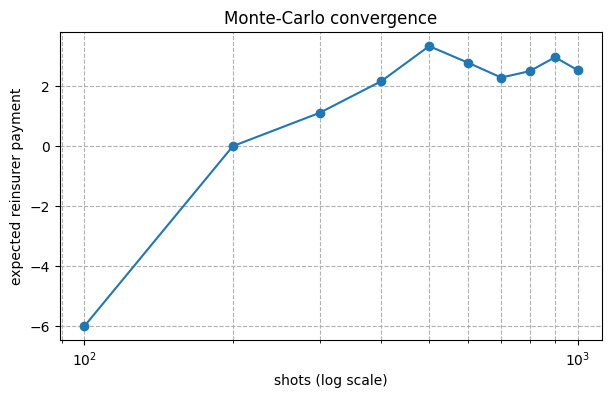

,shots,expected_payment
0,100.0,-6.000000
1,200.0,0.000000
2,300.0,1.111111
3,400.0,2.166667
4,500.0,3.333333
5,600.0,2.777778
6,700.0,2.285714
7,800.0,2.500000
8,900.0,2.962963
9,1000.0,2.533333


In [ ]:
df_conv = convergence_study(qc,
                            meas_idx=meas_q,
                            c_param=c_param,
                            coins=coins,
                            shot_grid=np.linspace(100, 1_000, 10))
# Save for later comparison, if you like
df_conv.to_csv("mc_convergence.csv", index=False)
df_conv

## Classical Monte Carlo

In [ ]:
import scipy.stats as stats

np.random.seed(42)  # For reproducibility

cmc_samples = 100_000

cmc_results = np.zeros(cmc_samples)
cmc_results_0_10 = np.zeros(cmc_samples)
for i in range(cmc_samples):
    # Sample lognormal
    lnorm = stats.lognorm.rvs(sigma, loc=0, scale=np.exp(mu))

    # Calculate payout
    payout = 0 if lnorm <= 1 else lnorm - (1 - coins) * (lnorm - deductible) - deductible
    
    # Store the results
    cmc_results[i] = payout

    # Calculate clipped payout on [0, 10]
    lnorm_0_10 = lnorm if lnorm <= 10 else 10
    payout_0_10 = 0 if lnorm_0_10 <= 1 else lnorm_0_10 - (1 - coins) * (lnorm_0_10 - deductible) - deductible
    cmc_results_0_10[i] = payout_0_10


C:\Users\alexf\AppData\Local\Temp\ipykernel_60532\2597867.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.axis([0, None, 0, None])


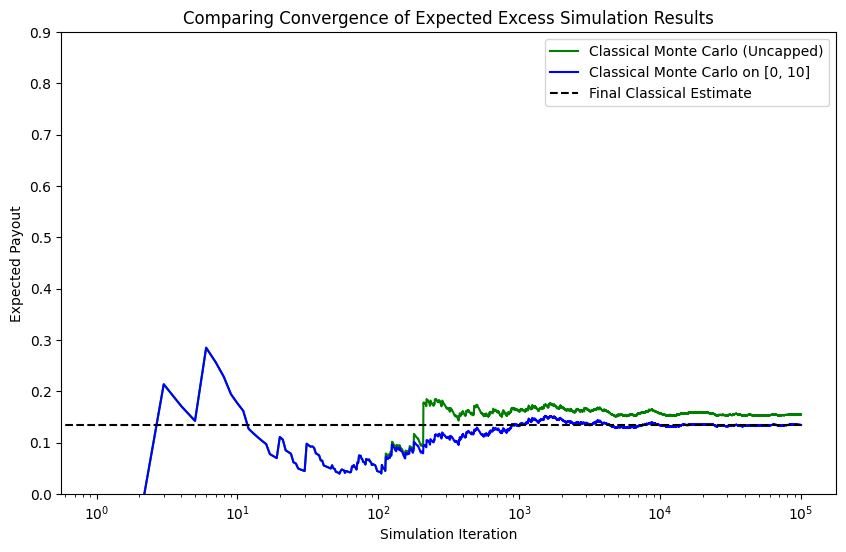

In [ ]:
cmc_running_mean = np.cumsum(cmc_results) / np.arange(1, len(cmc_results) + 1)
cmc_running_mean_0_10 = np.cumsum(cmc_results_0_10) / np.arange(1, len(cmc_results_0_10) + 1)
cmc_x = range(cmc_samples)

# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
plt.plot(cmc_x, cmc_running_mean, 'g-', label='Classical Monte Carlo (Uncapped)')
plt.plot(cmc_x, cmc_running_mean_0_10, 'b-', label='Classical Monte Carlo on [0, 10]')
# plt.plot(df_conv["shots"], df_conv["expected_payment"], 'r-', label='Quantum Monte Carlo on [0, 10]')
plt.hlines(y=cmc_running_mean_0_10[-1], xmin=0, xmax=cmc_samples, color='k', linestyle='--', label='Final Classical Estimate')
plt.legend(loc='best')
plt.title('Comparing Convergence of Expected Excess Simulation Results')
plt.xlabel('Simulation Iteration')
plt.ylabel('Expected Payout')
plt.ylim(0, 0.9)
plt.xscale('log', base=10)
plt.axis([0, None, 0, None])
plt.show()

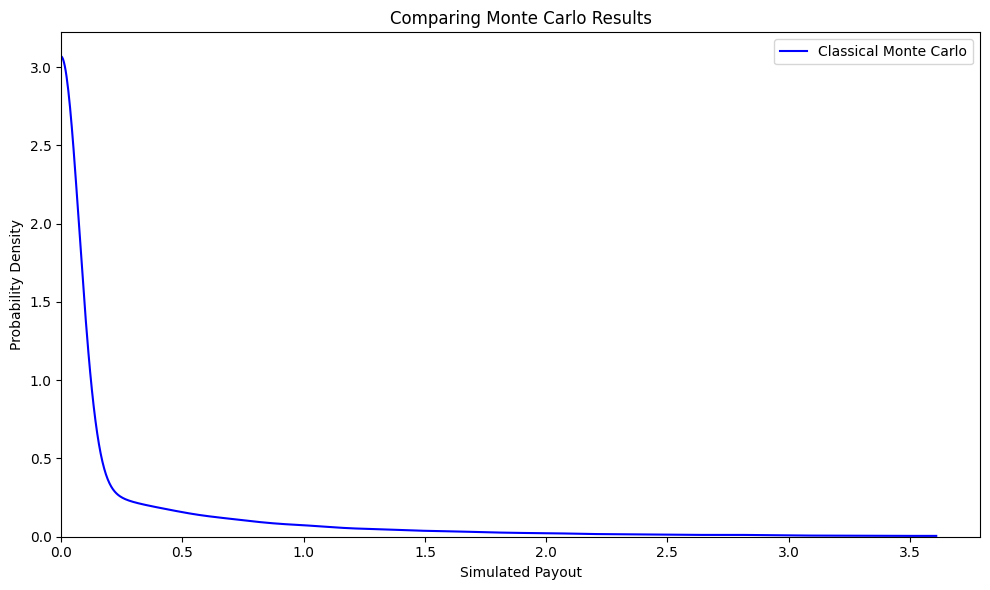

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6)) #, dpi=300)
cmc_results_kde = stats.gaussian_kde(cmc_results)
cmc_x = np.linspace(0, np.percentile(cmc_results, 99) * 1.1, 1000)
plt.plot(cmc_x, cmc_results_kde(cmc_x), 'b-', label='Classical Monte Carlo')
# plt.plot(cmc_x, cmc_results_kde(cmc_x), 'r--', label='Quantum Monte Carlo')
plt.legend(loc='best')
plt.title('Comparing Monte Carlo Results')
plt.xlabel('Simulated Payout')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.axis([0, None, 0, None])
plt.show()